## FII_SMART Multi-evidence Natural Language Inference for Clinical Trial Data


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jun  5 20:34:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import sys
import os

DEBUG1=False
DEBUG2=False

PREFIXG="/content/"
PREFIX="/content/"

TRAIN_DATA=PREFIXG+"train.csv"
TEST_DATA=PREFIXG+"dev.csv"
TEST_DATA2=PREFIXG+"test.csv"

Clean files for new run

In [ ]:
from google.colab import files

!ls
!rm test.*
!rm train.*
!rm dev.*
!rm subm*.*
!rm test-*.*
!rm results-*.*
!rm -rf CT_data
!rm CT_data.zip
!rm dataset.zip

CT_data					       results_2_20230605202123.json
CT_data.zip				       results_3_20230605202247.json
dataset.zip				       results_4_20230605202548.json
dev.csv					       results_5_20230605202714.json
dev.json				       sample_data
NLI4CT_numerical_instances_dataset.json        submission_1_20230605201923.csv
NLI4CT_numerical_instances_dev.json	       submission_2_20230605202123.csv
pairs_NLI4CT_numerical_instances_dataset.json  submission_3_20230605202247.csv
pairs_NLI4CT_numerical_instances_dev.json      submission_4_20230605202548.csv
results_1_20230605191003.json		       submission_5_20230605202714.csv
results_1_20230605192043.json		       test
results_1_20230605194847.json		       test.csv
results_1_20230605200336.json		       test.json
results_1_20230605201057.json		       train.csv
results_1_20230605201923.json		       train.json
results_2_20230605193211.json
rm: cannot remove 'test-*.*': No such file or directory
rm: cannot remove 'results-*.*': No such file or directory


In [ ]:
!pip install transformers > /dev/null 2>&1
!wget https://github.com/volosincu/FII_Smart__Semeval2023/raw/main/dataset.zip
!unzip /content/dataset.zip
!unzip /content/CT_data.zip  > /dev/null 2>&1

--2023-06-05 20:34:15--  https://github.com/volosincu/FII_Smart__Semeval2023/raw/main/dataset.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/volosincu/FII_Smart__Semeval2023/main/dataset.zip [following]
--2023-06-05 20:34:15--  https://raw.githubusercontent.com/volosincu/FII_Smart__Semeval2023/main/dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2479891 (2.4M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]   2.36M  --.-KB/s    in 0.08s   

2023-06-05 20:34:16 (31.3 MB/s) - ‘dataset.zip’ saved [2479891/2479891]

Archive:  /content/dat

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
print(stopwords.words('english'))

STOP_WORDS_RO = [ ]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Tests for numerical regex  

In [ ]:
with open('test', encoding='utf-8', mode='w+') as f:
    f.write('\u4500 blah blah blah\n')
    f.seek(0)
    print(repr(f.readline()[:1]))

import unicodedata    
raw_text = "Patients with Platelet count over 100,000/mm\u00ac\u00a8\u201a\u00e2\u2022, ANC "
convert_text = unicodedata.normalize('NFKD', raw_text)
convert_text

'䔀'


'Patients with Platelet count over 100,000/mm¬ ̈‚â•, ANC '

In [ ]:
n7sample =  ["Inclusion Criteria: The following criteria are to be checked at the time of study entry  The patients may only be included in the study if ALL of the following statements are FULLFILLED: The patient (male or female) is at least 18 years old at the time of signature of the informed consent form  Written informed consent has been obtained from the patient prior to the performance of any protocol-specific procedure  The patient is diagnosed with confirmed invasive breast cancer with stage IV disease  Note: If the metastatic disease is restricted to a solitary lesion  its neoplastic nature should be confirmed by cytology or histology  The patient has documented disease progression or relapse following at least one prior standard therapy with trastuzumab (alone or in combination with chemotherapy)  Patients with prior lapatinib use are eligible  Furthermore  The administration of the chemotherapeutic agent(s) should have been stopped for at least 28 days by the time of the first ASCI administration  The administration of trastuzumab alone could be maintained after chemotherapy  but the last dose of trastuzumab should not have been given less than three weeks before the first ASCI administration  The patient will not be given trastuzumab during the trial  For metastatic patients whose disease is ER+ and/or PR+ the following criteria should be met: Patients with visceral disease that requires chemotherapy (eg.  patients with liver or lung metastases)  Rapidly progressing or life threatening disease  as determined by the investigator  Patients who received hormonal therapy and are no longer benefiting from this therapy  A tumor lesion from the patient biopsied before or during screening shows either: ",
            "Overexpression of the HER2 protein  as determined by immunohistochemistry (IHC  with result IHC 3+) orAmplification of the HER2 gene as determined by FISH (at least 4 fold i.e  at least 8 copies)  Note: Overexpression/amplification measurements must be performed on a metastatic lesion in all cases where such a lesion is sufficiently easily accessible  If however such a biopsy is not possible  then these measurements can be performed on the primary tumor  Use of the primary tumor is to be documented and justified  Ten FFPE tissue sections of the tumor on which the HER2 overexpression/amplification has been done -if available-may be requested  These may be used to retrospectively carry out part of the translational research (i.e  analysis of EGF receptor activity and of the presence of immune effector cells  refer to Section 7). The patient has at least one measurable lesion according to RECIST criteria  The patient has ECOG status of 0 or 1. The patient has adequate bone marrow reserve as indicated by: White blood cell count greater than /= 3,000/mm3. Neutrophil count greater than /= 1,500/mm3. Platelet count greater than /= 100,000/mm3. Hemoglobin levels greater than /= 10.0 g/dl  The patient has adequate renal function as shown by the creatinine levels (i.e  within the normal range)  The patient has adequate hepatic function as shown by serum bilirubin levels i.e: Serum bilirubin levels within the normal limits  ",
            "Both AST and ALT levels smaller than 1.5 times the ULN  Note: However  for patients with liver metastasis  a serum bilirubin level smaller than 1.5 times the ULN and both AST and ALT levels smaller than 3 times the ULN will be accepted The patient has a baseline Left Ventricular Ejection Fraction (LVEF) measured by MUGA scan equal to or greater than the LLN for the radiology facility  If the patient is female  she must be of non-childbearing potential  i.e  have a current tubal ligation  hysterectomy  ovariectomy or be post-menopausal  or if she is of childbearing potential  she must practice adequate contraception for 30 days prior to treatment  have a negative pregnancy test and continue such precautions for two months after completion of the study treatment  Adequate contraception is defined as a contraceptive method with failure rate of less than 1% per year when used consistently and correctly (when applicable  as mentioned in the product label) for example abstinence  combined or progestogen oral contraceptives  injectable progestogen  implants of levonorgestrel  oestrogenic vaginal ring  percutaneous contraceptive patches or intrauterine device (IUD) or intrauterine system (IUS)  vasectomy with documented azoospermia of the sole male partner or double barrier method (condom or occlusive cap plus spermicidal agent)  ",
            "For azoospermia  \"documented\" refers to the outcome of the investigator's/ designee's medical examination of the subject or review of the subject's medical history for study eligibility  as obtained via a verbal interview with the subject or from the subject's medical records Post-menopause: Menopause is the age associated with complete cessation of menstrual cycles  menses  and implies the loss of reproductive potential by ovarian failure  A practical definition accepts menopause after 1 year without menses with an appropriate clinical profile at the appropriate age e.g  greater than 45 years  Able to swallow and retain oral medication  In the view of the investigator  the patient can and will comply with the requirements of the protocol  Exclusion Criteria: The following criteria should be checked at the time of study entry  If any apply  the patient must not be included in the study: The patient has received greater than 300 mg/m2 doxorubicin (cumulative dose) or greater than 600 mg/m2 epirubicin (cumulative dose)  The patient is receiving treatment with bisphosphonate UNLESS the biphosphonate treatment was initiated more than three weeks before the first ASCI administration  (See also section 5.3.2.). The patient has received any investigational or non-registered product (drug or vaccine) other than the study treatment(s) within 30 days preceding the first dose of study treatment  or planned use during the study period  The patient is currently receiving amiodarone or has received amiodarone in the 6 months prior to screening  ",
            "The patient requires concomitant treatment with systemic corticosteroids or any immunosuppressive agents  The use of prednisone  or equivalent  smaller than 0.5 mg/kg/day (absolute maximum 40 mg/day)  or inhaled corticosteroids or topical steroids is permitted The patient has a malabsorption syndrome  disease significantly affecting gastrointestinal function  or resection of the stomach or small bowel  Patients with ulcerative colitis  The patient has known coronary artery disease  arrhythmia requiring treatment  clinically significant valvular disease  cardiomegaly on chest X-ray  ventricular hypertrophy (found by ECG) or previous myocardial infarction  The patient has any acute or chronic  clinically significant pulmonary  cardiovascular  hepatic or renal functional abnormality  as determined by physical examination or laboratory screening tests  The patient has current active hepatic or biliary's disease (with exception of patients with Gilbert's syndrome  asymptomatic gallstones  liver metastases or stable chronic liver disease per investigator assessment)  The patient presents with autoimmune disease (vitiligo and autoimmune thyroid disease is not an exclusion criterion)  The patient has a known family history of congenital or hereditary immunodeficiency  The patient has any uncontrolled bleeding disorder or coagulation disorder or thrombocytopenia or pro-thrombotic disorder  The patient has a history of anaphylaxis or severe allergic reaction to vaccines or unknown allergens  ",
            "The patient has a known immediate or delayed hypersensitivity reaction or idiosyncrasy to drugs chemically related to Lapatinib  These include other anilinoquinazolines  such as gefitinib (Iressa)  erlotinib (Tarceva)  or other chemically related compounds or excipients The patient is known to be positive for the Human Immunodeficiency Virus (HIV)  The patient has (or has had) previous or concomitant malignancies at other sites except effectively treated: Non-melanoma skin cancers or carcinoma in situ of the cervix Malignancy that has been in remission for greater than 2 years and is considered highly likely to have been cured  The patient has any psychiatric or addictive disorder that may compromise her ability to give informed consent  or to comply with the trial procedures  The patient has any other condition that in the opinion of the investigator might jeopardize the patient's safety or ability to comply with the requirements of the study  The patient is pregnant or lactating  "]

n6sample = "Inclusion Criteria: Subjects who were confirmed to have a response after receiving at least two courses of weekly paclitaxel therapy and considered to need to continue the therapy by the investigator/subinvestigator among the patients with advanced or recurrent breast cancer who had met the selection criteria and participated in the preceding phase II clinical study Inclusion Criteria: The patient must consent to be in the study and must have signed an approved consent form conforming to institutional guidelines The patient must be 18 years or older  Core biopsy should definitively demonstrate invasive carcinoma  Invasive carcinoma should be ER-apha receptor positive The tumor should be approximately at least 1 cm  to account for variability in imaging and imaging occult disease (physical exam  mammography  ultrasound)  We recognize that from time to time because of this variation  there might not be enough tissue available for analysis after surgical excision but this will allow the greatest opportunity to capture as many eligible patients as possible  Patients in whom surgical excision of the tumor is part of standard of care management ECOG score of 0 or 1 Negative serum or urine beta-hCG pregnancy test at screening for patients of child-bearing potential (this is routinely done if the patient is premenopausal and having surgery) Consent to participate in DBBR (RPCI only) Exclusion Criteria: Male patients are not eligible for this study Female patients with inoperable tumors or women with stage 4 disease diagnosed on CT  PET  PET/CT or bone scan  Patients with diagnosis by FNA cytology only Pregnant or lactating women Prior therapy for breast cancer  including irradiation  chemo- immuno- and/or hormonal therapy Patients receiving any hormonal therapy  e.g  ovarian hormonal replacement therapy  infertility medications etc.  are not eligible "

n5sample = 'flaxseed or soy products or black cohosh  Patients with a known mutation in p53 (Li Fraumeni Syndrome) '

n4sample =  "Inclusion Criteria: Clinical stage I or II (T1 or T2, N0 or N1) invasive mammary carcinoma Exclusion Criteria: Fixed axillary lymph node metastases (N2) "

n3sample = "II-IV"

In [ ]:
import re

def uninorm(w):
  return unicodedata.normalize('NFKD', w)

def remove_partitions(numInstances, skip=False):
  if skip:
    return numInstances
  b1 = []
  for w in numInstances:
    a0 = numInstances[0:]
    a0.remove(w)
    contained = False
    for x in a0:
      if w.strip() in x.strip():
        contained = True
    if not contained:
      b1.append(w.strip())
  return b1

def getCohorts(sentence):
  sa02 = re.findall(r'Adverse[\s]{0,3}Events[\s1]+\:.+Adverse[\s]{0,3}Events[\s2]+\:', sentence, re.UNICODE)
  sa03 = re.findall(r'Adverse[\s]{0,3}Events[\s2]+\:.+(?:Adverse[\s]{0,3}Events[\s3]+\:)', sentence, re.UNICODE)
  return sa02 + sa03

def containsNumericalInstances(sentence, skip=False):
  # '2,0 mg/dl', '9,7 mg'
  s00 = re.findall(r'[0-9]+,[0-9]+\s{1}[a-zA-Z\/\^\-\:\+\*\=,0-9]+', sentence, re.UNICODE) # ['9,7 mg']  # ['9,7 test']
  # s01 = re.findall(r'^[0-9]+\s{0,1}[a-zA-Z0-9]+[\^\/\-_]{1}[a-zA-Z0-9]+|(?:\s)[0-9]+\s{0,1}[a-zA-Z0-9]+[\^\/\-_]{1}[a-zA-Z0-9]+', sentence, re.UNICODE)  # 50 mg/min
  s010 = re.findall(r'^[0-9]+\s{0,1}[a-zA-Z0-9]+[\^\/\-_]{1}[a-zA-Z0-9]+|(?:\s)[0-9]+\s{0,1}[a-zA-Z0-9]+[\^\/\-_]{1}[a-zA-Z0-9]+(?:\s{1}[a-zA-Z]+)', sentence, re.UNICODE)  # 50 mg/min
  s02 = re.findall(r'[^a-zA-Z][0-9]+[\.\,]{1}[0-9%]+\s{0,1}[a-zA-Z]+[\^\/\-_]{1}[a-zA-Z]+', sentence, re.UNICODE)  # 2.0 mg/dl, ' 9.0 g/dL'
  s020 = re.findall(r'[^a-zA-Z\S][0-9]+\s{0,1}[a-zA-Z]+[\^\/\-_]{1}[a-zA-Z\S]+', sentence, re.UNICODE)  # 2.0 mg/dl, ' 300 mg/m2'
  # the ALT 2.5 times , 'Hemoglobin 9.0 g/dL'
  s021 = re.findall(r'\w+\s[0-9]+[\.\,]{1}[0-9%]+\s{0,1}[a-zA-Z]+[\^\/\-_\s]{1}[a-zA-Z0-9]+', sentence, re.UNICODE)

  # 'T1N1-3M0'
  s022 = re.findall(r'\w+[0-9]+\S{1}\s{0,1}[a-zA-Z0-9]+[a-zA-Z0-9]+', sentence, re.UNICODE)
  s023 = re.findall(r'\w+\s\w+\s[0-9\:]+\S{0,1}', sentence, re.UNICODE)
  # '1-21. Inclusion', ['9,7 test'], '9,7 test', '88888888/55 9/8' , '52-75 years', '9/8 mg', '1/50 mg', '2/neu positive', '0-1 ANC', '1,500/mm³ Platelet', '100,000/mm³ Hemoglobin'
  s03 = re.findall(r'[\(\[\{\<]*[0-9]+[,\-\:\+\=\@\#\/][0-9%\.\S]+[\)\]\}\>]{0,1}\s{1}[a-zA-Z\/\^\-\:\+\*\=,0-9]+', sentence, re.UNICODE) 
  # '(300%) than'
  s030 = re.findall(r'[\(\[\{\<]{1}\w*[0-9]+\w*[,\-\:\+\=\@\#\/]*[0-9%]*[\)\]\}\>]{1}\s{0,1}(?:\s{1}[a-zA-Z]+)', sentence, re.UNICODE)
  # '8,88888888/55 mg', '9/8 mg', '1/50 mg', '5.5/5.0 11', '3.74/9.45666 11'
  s1 = re.findall(r'[0-9]+[\.\,\-\:\+\=\@\#\/]{0,1}[0-9]*[\/][0-9]+[\.\,\-\:\+\=\@\#\/]{0,1}[0-9]*\s{1}[a-zA-Z\S]+[\^\/\-_]{0,1}[a-zA-Z0-9\S]+', sentence, re.UNICODE) 
  # 'y3.222 mg', 'f3.566 mg/kg', 'Ki67 staining'
  s10 = re.findall(r'[a-zA-Z]+[0-9]+[\.\,\-\:\+\=\@\#\/]{0,1}[0-9%]+\s{1}[a-zA-Z]+[\^\/\-_]{0,1}[a-zA-Z]+', sentence, re.UNICODE) 
  # '61.1% mg', '65.5 % mg'
  s2 = re.findall(r'[0-9]+[\.\,\-\:\+\=\@\#\/]{0,1}[0-9]*\s{0,1}%\s{1}[a-zA-Z]+[\^\/\-_]{0,1}[a-zA-Z]+', sentence, re.UNICODE) 
  # s21 = re.findall(r'([0-9]+[\.]{0,1}[0-9]*)[\s]{0,1}%[\s]{0,1}[a-zA-z]+', sentence)  # '5.5/5.0', '3.7/9.0', '3.74/9.45666',
  # '5.5/5.0 11 mg ', '3.7/9.0 11 mg ', '3.74/9.45666 11 mg '
  s3 = re.findall(r'[0-9%]+[\.\,\-\:\+\=\@\#\/]{0,1}[0-9%]*[\/][0-9%]+[\.\,\-\:\+\=\@\#\/]{0,1}[0-9%]+(?!\s{1}[a-zA-Z0-9])', sentence, re.UNICODE) 
  #'5.5/5.0 11 mg ', '3.7/9.0 11 mg ', '3.74/9.45666 11 mg ',  '8,88888888/55 9/8 ', '3.7/9.0 11  '
  s41 = re.findall(r'[0-9]+[\.\,\-\:\+\=\@\#\/]{0,1}[0-9]*[\/][0-9]+[\.\,\-\:\+\=\@\#\/]{0,1}[0-9]*\s{1}[\s\d\^\/\-_]+[a-zA-Z]{,4}\s{1}', sentence, re.UNICODE)
  #s3 = re.findall(r'[0-9]+[\.]{0,1}[0-9]*\s{0,1}%', sentence) # '61.1%', '65.5 %'
  # ' 2 months of', ' 12 weeks ECOG', ' 200 mg test'
  s50 = re.findall(r'\s[0-9]+\s{1}[a-zA-Z]+(?:\s[a-zA-Z0-9;]+)', sentence, re.UNICODE)
  s51 = re.findall(r'\s{0,1}[0-9]+\s{1}[a-zA-Z]+(?:\s[0-9a-zA-Z;\.\,\:\?\[\(\{\}\]\)\=]+\s)', sentence, re.UNICODE)
  s60 = re.findall(r'[0-9]+[\.\,\-\:\+\=\@\#\/]{1}[0-9]+[\.\,\-\:\+\=\@\#\/]{1}[a-zA-Z][\S]*', sentence, re.UNICODE) #'100,000/mm³'
  s61 = re.findall(r'[0-9]+[\.\,\-\:\+\=\@\#\/]{1}[0-9]+[\.\,\-\:\+\=\@\#\/]{1}[a-zA-Z][\S]*(?:\s[a-zA-Z]+)', sentence, re.UNICODE) #'100,000/mm³'
  # s70 = re.findall(r'[0-9]+[\.,]{1}[0-9]+[\^\/\-_]{1}[a-z][\S]*', sentence) #'100,000/mm³'
  s80 = re.findall(r'[0-9]+[\.\,\-\:\+\=\@\#\/]{1}[0-9]+[\.\,\-\:\+\=\@\#\/]{1}[a-zA-Z][\S]*(?:\s[a-zA-Z]+)', sentence, re.UNICODE) #'100,000/mm³'
  s90 = re.findall(r'[0-9]+[\.\,\-\:\+\=\@\#\/]{1}[0-9]+[\.\,\-\:\+\=\@\#\/]{1}[a-zA-Z][\S]*', sentence, re.UNICODE) #'100,000/mm³'
  sa01 = re.findall(r'primary|secondary|third|first|all|at least|last', sentence, re.UNICODE) 
  #return sa03;
  strs = s010 + s02 + s020 + s021 + s022 + s023 + s03 + s030 + s00 + s10 + s1 + s2 + s41 + s50 + s51 + s60 + s61 + s90 + sa01
  insts = set([s.strip() for s in strs])
  return remove_partitions(list(insts), skip)


n6sample


# a95 = getCohorts("Adverse Events 1: Total: 4/26 (15.38%) Febrile neutropenia * 1/26 (3.85%) Gastric volvulus * 20/26 (0.00%) General Malaise * 21/26 (3.85%) Hospitalisation for intrapleuric chemotherapy and thoracentesis * 21/26 (3.85%) Acute renal failure * 21/26 (3.85%) Adverse Events 2: Total: 1/28 (3.57%) cases of CHF in the primary trial  were in secondary and third Febrile neutropenia more adverse events in cohort 1 of the primary trial  than in cohort 2. ")
# print(a95)
# a96 = getCohorts("Adverse Events 1: Cardiac failure congestive 1/32 (3.13%) Adverse Events 2: Cardiac failure congestive 0/20 (0.00%) Adverse Events 3: Cardiac failure congestive 8/32 (33.13%)")
# print(a96)

# a97 = containsNumericalInstances("Adverse Events 1: Total: 4/26 (15.38%) Febrile neutropenia * 1/26 (3.85%) Gastric volvulus * 20/26 (0.00%) General Malaise * 21/26 (3.85%) Hospitalisation for intrapleuric chemotherapy and thoracentesis * 21/26 (3.85%) Acute renal failure * 21/26 (3.85%) Adverse Events 2: Total: 1/28 (3.57%) cases of CHF in the primary trial  were in secondary and third Febrile neutropenia more adverse events in cohort 1 of the primary trial  than in cohort 2. ")
# print(a97)
# a99 = containsNumericalInstances(' Patients should have T1N1-3M0 or T2-4 N0-3M0. Patients with Platelet count over 100,000/mm\u00ac\u00a8\u201a\u00e2\u2022, ANC smaller than 1,700/mm\u00ac\u00a8\u201a\u00e2\u2022 and Hemoglobin between 4 to 5 grams per deciliter to 28 days; are eligible for the primary trial ', True)
# print(a99)
# print(str(a99)==str(['2-4 N0-3M0', '1-3M0 or', '100,000/mm¬¨‚â•, ANC', '1,700/mm¬¨‚â•', '100,000/mm¬¨‚â•,', '5 grams per', '1,700/mm¬¨‚â• and']))
# a98 = containsNumericalInstances("Patients with HER-2/neu positive tumors asymptomatic for 2 months of progression status not  expectancy 12 weeks ECOG performance status 0-1 ANC 1,500/mm³ Platelet count 100,000/mm³ Hemoglobin 9.0 g/dL ", True)
# print(a98)
# print(str(a98)==str(['100,000/mm³ Hemoglobin', '0-1 ANC', '100,000/mm³', '2/neu positive', '12 weeks ECOG', '9.0 g/dL', '2 months of', '1,500/mm³ Platelet', '1,500/mm³']))
# a0 = containsNumericalInstances(" Ki67 staining (cumulative dose) and the ALT 2.5 times daily on days 1-21. Inclusion Criteria: Age 52-75 years old; IdentificationPatients also receive cixutumumab IV over 1-1\u00bd hours on days 1, 8, and 15. Courses repeat ", True)
# print(a0)
# print(str(a0)==str(['1-21. Inclusion', '52-75 years', '1-1½ hours', 'Ki67 staining']))
# a1 = containsNumericalInstances("Moni dict (300%) than 300 mg/m2 doxorubicin (cumulative dose) or greater than 600 mg/m2 epirubicin sdfsdf  fff  fdfsd", True)
# print(a1)
# print(str(a1)==str(['(300%) than', '600 mg/m2 epirubicin', '300 mg/m2 doxorubicin', '300 mg/m2', '600 mg/m2']))
# test2 = containsNumericalInstances("e {5.7%} mg Age 52-75 years old; 100,000/mm³ 200 mg test 50 mg/min 2.0 mg/dl i f3.566 mg 66|8 t/8 9,7 test 8,88888888/55 9/8 3.7/9.0 11  61.1% 65.5 % [2]1/50", True)
# print(test2)
# print(str(test2)==str(['9,7 test', 'f3.566 mg', '3.7/9.0 11', '200 mg test', '8,88888888/55 9/8', '100,000/mm³ 200', '100,000/mm³', '2.0 mg/dl', '7/9.0 11', '50 mg/min', '52-75 years']))
# test3 = containsNumericalInstances("Age 52-75 years old;  100,000/mm³ vals 200 mg 50 mg/min 2,0 mg/dl y3.222 mg i f3.566 mg/kg 66|8 mg t/8 mg 9,7 mg test 8,88888888/55 mg 9/8 mg 5.5/5.0 11 mg 3.7/9.0 11 mg 3.74/9.45666 11 mg 61.1% mg 65.5 % mg [2]1/50 mg", True)
# print(test3)
# print(str(test3)==str(['9/8 mg', '3.74/9.45666 11', '3.74/9.45666 11 mg', '5.5/5.0 11', '3.7/9.0 11 mg', '61.1% mg', 'y3.222 mg', '100,000/mm³ vals', 'f3.566 mg/kg', '9,7 mg', '5.5/5.0 11 mg', '100,000/mm³', '8,88888888/55 mg', '1/50 mg', '3.7/9.0 11', '65.5 % mg', '2,0 mg/dl', '74/9.45666 11', '7/9.0 11', '50 mg/min', '52-75 years', '5/5.0 11']))
# test4 = containsNumericalInstances("a {5.7} mg Age 52-75 years old; 100,000/mm³ vals 200 mg (200 mg) 50 mg/min 2.0 mg/dl y3.222 mg i f3.566 mg/kg 66|8 mg t/8 mg (9,7%) [9,7%] 9,7 mg test 8,88888888/55 mg 9/8 mg 5.5/5.0 11 mg 3.7/9.0 11 mg 3.74/9.45666 11 mg 61.1% mg 65.5 % mg [2]1/50 mg", True)
# print(test4)
# print(str(test4)==str(['9/8 mg', '3.74/9.45666 11', '3.74/9.45666 11 mg', '5.5/5.0 11', '3.7/9.0 11 mg', '61.1% mg', 'y3.222 mg', '100,000/mm³ vals', 'f3.566 mg/kg', '9,7 mg', '[9,7%] 9,7', '5.5/5.0 11 mg', '100,000/mm³', '8,88888888/55 mg', '1/50 mg', '3.7/9.0 11', '65.5 % mg', '74/9.45666 11', '2.0 mg/dl', '7/9.0 11', '50 mg/min', '52-75 years', '5/5.0 11']))
# print(['                                  8,88888888/55 mg', '9/8 mg', '1/50 mg', '61.1% mg', '65.5 % mg', '5.5/5.0', '3.7/9.0', '3.74/9.45666', '5.5/5.0 11 mg ', '3.7/9.0 11 mg ', '3.74/9.45666 11 mg '])

'Inclusion Criteria: Subjects who were confirmed to have a response after receiving at least two courses of weekly paclitaxel therapy and considered to need to continue the therapy by the investigator/subinvestigator among the patients with advanced or recurrent breast cancer who had met the selection criteria and participated in the preceding phase II clinical study Inclusion Criteria: The patient must consent to be in the study and must have signed an approved consent form conforming to institutional guidelines The patient must be 18 years or older  Core biopsy should definitively demonstrate invasive carcinoma  Invasive carcinoma should be ER-apha receptor positive The tumor should be approximately at least 1 cm  to account for variability in imaging and imaging occult disease (physical exam  mammography  ultrasound)  We recognize that from time to time because of this variation  there might not be enough tissue available for analysis after surgical excision but this will allow the 

In [ ]:
def containsNr(word):
  return re.findall(r'\d', word)

def nnChunk(chunk):
  _word = chunk
  word = None
  withSeparator = False;
  if _word.startswith(';'):
     word = _word[1:]
  # elif _word.endswith(')'):
  #   word = _word[:len(_word)-1]
  if _word.endswith(','):
    if not containsNr(_word):
      word = _word[:len(_word)-1]+" "
    else:
      word = _word
  elif _word.endswith('.'):
    if not containsNr(_word):
      word = _word[:len(_word)-1]+" "
    else:
      word = _word
  else:
    word = _word
  return word

# punctuation = ['„', '”', '(', ')', ';', '{', '}','[',']', '/', '\\',"\"", "'", ','] 
punctuation = ['„', '”', ';', '\\',"\"", "'"] 

def normalizeChunk(chunk):
  concats=[]
  # for sign in punctuation:
  #   if(word.__contains__(sign)):
  c = chunk.split(" ")
  for w in c:
    sw = nnChunk(w)
    concats.append(sw)
  if(len(concats) == 0):
    concats.append(chunk)
  return list(filter(None, dict.fromkeys(concats)))

print(normalizeChunk("3.5 mg, casa,Stage IV."))
print(normalizeChunk("3.5 mg. casa,Stage IV"))
print(normalizeChunk("3 casa,Stage IV"))
print(normalizeChunk("3casa.Stage IV"))
normalizeChunk(normalizeChunk("3casa.Stage IV")[0])

['3.5', 'mg ', 'casa,Stage', 'IV ']
['3.5', 'mg ', 'casa,Stage', 'IV']
['3', 'casa,Stage', 'IV']
['3casa.Stage', 'IV']


['3casa.Stage']

In [ ]:
b = "FLT PET scan at baseline and 1-6 weeks after the start"
# b = "than patients in the"
a = 'The surgery follows 1-7 days after the second FLT PET'


def concat(*args):
    result = ''
    for arg in args:
        result = _concat(result, arg)
    return result

def _concat(a, b):
    la = len(a)
    lb = len(b)
    for i in range(la):
        j = i
        k = 0
        while j < la and k < lb and a[j] == b[k]:
            j += 1
            k += 1
        if j == la:
            n = k
            break
    else:
        n = 0
    return a + b[n:]


def can_concat(a, b):
    la = len(a)
    lb = len(b)
    for i in range(la):
        j = i
        k = 0
        while j < la and k < lb and a[j] == b[k]:
            j += 1
            k += 1
        if j == la:
            n = k
            break
    else:
        n = 0

    if (n>3):
      return True
    if (n==0):
      return False
    return False

concat(b, a)

'FLT PET scan at baseline and 1-6 weeks after the startThe surgery follows 1-7 days after the second FLT PET'

In [ ]:
from difflib import SequenceMatcher
a = "FLT PET scan at baseline and 1-6 weeks after the start"
# b = "than patients in the"
b = 'The surgery follows 1-7 days after the second FLT PET'

def mxrint(ttx, tx=''):
  if 1==2:
    print(ttx, tx)

def merge_num_instances(a, b):
  s = SequenceMatcher(lambda x: x==" ", a, b)
  mtch = s.find_longest_match(0, len(a), 0, len(b))
  mst = mtch[0]
  mnd = mtch[1]
  msz = mtch[2]
  if (a in b):
    return b
  if (b in a):
    return a

  if (can_concat(a, b)):
    return _concat(a, b)
  
  if (can_concat(b, a)):
    return _concat(b, a)

  if (mst > mnd):
    if (mnd>0):
      mxrint('Not from same sentence. exit')
      return a
    na = a[:mst]+b
    if (msz+mst == len(a)):
      mxrint(len(na), msz+mst == len(a))
    else:
      mxrint('Not continous')
      return a
    return na
  else:
    nb = b[:mnd]+a
    if (mst>0):
      mxrint('Not from same sentence. exit')
      return a
    if (msz+mnd == len(b)):
      mxrint('continous')
    else:
      mxrint('Not from same sentence. exit')
      return a
    return nb
# merge_num_instances(b, a)

array = ['than 1/4 patients in the primary',
         'the primary trial experienced',
         'than 1/4 patients in the',
         'Less than 1/4 patients',
         '8/24 (33.33%)',
         'Adverse Events 1:']

array = ['PATIENT CHARACTERISTICS: ANC 1,500/mm³ Platelet count 100,000/mm³ Hemoglobin 9.0 g/dL', 'ANC 1,500/mm³ Platelet count 100,000/mm³ Hemoglobin 9.0 g/dL', 'PATIENT CHARACTERISTICS: ANC 1,500/mm³ Platelet count 100,000/mm³ Hemoglobin 9.0 g/dL', '1,500/mm³ Platelet count 100,000/mm³ Hemoglobin 9.0 g/dL', 'ANC 1,500/mm³ Platelet count 100,000/mm³ Hemoglobin 9.0 g/dL']

array = ['PATIENT', 'yhsy', 'abc', 'PATIENT', 'PAtIENT']

# 5bc844fc-e852-4270-bfaf-36ea9eface3d
array = [
            "Patients also receive cixutumumab IV over 1-1½ hours on days 1,",
            "endocrine treatment  The surgery follows 1-7 days after the second",
            "scan at baseline and 1-6 weeks after the start of standard endocrine",
            "twice daily on days 1-14 and oral lapatinib ditosylate once daily on",
            "stage  ER positive primary breast cancer undergo FLT PET",
            "IV over 1-1½ hours on days 1, 8, and 15. Courses repeat",
            "PO and capecitabine: Given PO INTERVENTION 2: Arm B Patients receive capecitabine",
            "emission tomography) scanning procedure: [F18] fluorothymidine  Positron Emission Tomography: Undergo",
            "days 1, 8, and 15. Courses repeat every 21 days in",
            "twice daily on days 1-14 and oral lapatinib ditosylate once daily",
            "FLT PET scan at baseline and 1-6 weeks after the start",
            "scan at baseline and 1-6 weeks after the start of standard",
            "oral capecitabine twice daily on days 1-14 and oral lapatinib ditosylate",
            "receive cixutumumab IV over 1-1½ hours on days 1, 8, and",
            "1-21. Courses repeat every 21 days in the absence of disease progression",
            "The surgery follows 1-7 days after the second FLT PET",
            "Analysis: Correlative studies - Ki67 staining of the tumor tissue in the",
            "The surgery follows 1-7 days after the second FLT PET scan",
            "Analysis: Correlative studies - Ki67 staining of the tumor tissue in",
            "once daily on days 1-21. Courses repeat every 21 days in",
            "on days 1-21. Courses repeat every 21 days in the absence of"
        ]


def continue_overlaping(array):
  if(len(array) == 1):
    return array

  arm = []
  for i in range(len(array)):
      for j in range(i + 1, len(array)):
        arm.append(merge_num_instances(array[j], array[i]))
  arm = list(set(arm))
  for i in range(len(array)):
    for j in range(i + 1, len(array)):
      arm.append(merge_num_instances(array[i], array[j]))

  rezultat = remove_partitions(list(set(arm)))

  for a in rezultat:
    for b in rezultat:
      s = SequenceMatcher(lambda x: x==" ", a, b)
      mtch = s.find_longest_match(0, len(a), 0, len(b))
      if (s.quick_ratio()>0.9):
        try:
          rezultat.remove(a)
        except:
          pass # do nothing

  return rezultat



continue_overlaping(array)
#len(" ".join(continue_overlaping(array)).split(" "))
# #merge_num_instances(a, b)


['Patients also receive cixutumumab IV over 1-1½ hours on days 1, 8, and 15. Courses repeat every 21 days in',
 'endocrine treatment  The surgery follows 1-7 days after the second FLT PET scan',
 'PO and capecitabine: Given PO INTERVENTION 2: Arm B Patients receive capecitabine',
 'stage  ER positive primary breast cancer undergo FLT PET scan at baseline and 1-6 weeks after the start',
 'oral capecitabine twice daily on days 1-14 and oral lapatinib ditosylate once daily on']

In [ ]:
def overlap_and_concatenate(array):
    concatenated = []
    overlap_found = False

    for i in range(len(array)):
        for j in range(i + 1, len(array)):
            if array[i] in array[j]:
                concatenated.append(array[j])
                overlap_found = True
                break

        if not overlap_found:
            concatenated.append(array[i])

    return concatenated

# Example usage:
array = ['than 1/4 patients in the primary',
         'the primary trial experienced',
         'than 1/4 patients in the',
         'Less than 1/4 patients',
         '8/24 (33.33%)',
         'Adverse Events 1:']

result = overlap_and_concatenate(array)
print(result)

#
# extinde contextul din jurul unei secvente dintr-o propozitie
#
def readSeqToSpace(sentence, seq):
    upToNSpaces = 5
    start = sentence.find(seq)
    newstartindex = start
    space_count_start = 0
    for i in range(start - 1, -1, -1):
        newstartindex = i + 1
        if sentence[i] == ' ':
            space_count_start += 1
            if space_count_start >= upToNSpaces:
                newstartindex = i + 1
                break
    end = start + len(seq)
    newendindex = end
    space_count_end = 0
    for i in range(end + 1, len(sentence)):
        if sentence[i] == ' ':
            newendindex = i
            space_count_end += 1
            if space_count_end >= upToNSpaces:
                newendindex = i
                break

    return (sentence[newstartindex-1:start] + sentence[start: newendindex]).strip()

xtz = "Less than 1/4 patients in the primary trial experienced adverse events "

print(readSeqToSpace(xtz, "than 1/"))
print(readSeqToSpace(xtz, "/4 patients"))

['than 1/4 patients in the primary', 'the primary trial experienced', 'than 1/4 patients in the', 'Less than 1/4 patients', '8/24 (33.33%)', 'Adverse Events 1:']
Less than 1/4 patients in the primary
Less than 1/4 patients in the primary trial experienced


In [ ]:
import spacy

def extract_information(sentence):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(sentence)

    action = None
    subject = None
    verb = None
    obj = None

    for token in doc:
        if token.dep_ == "ROOT" and token.pos_ == "VERB":
            action = token.lemma_
            verb = token.text
            break

    for token in doc:
        if token.dep_ == "nsubj":
            subject = token.text
        elif token.dep_ == "dobj" or token.dep_ == "attr":
            obj = token.text

    return {
        "action": action,
        "subject": subject,
        "verb": verb,
        "object": obj
    }

In [ ]:

nnsx = [
            "4 patients in",
            "primary",
            "1/4 patients",
            "Less than 1/"
        ]
[readSeqToSpace(xtz, nn) for nn in nnsx]

['Less than 1/4 patients in the primary trial experienced adverse',
 '1/4 patients in the primary trial experienced adverse events',
 'Less than 1/4 patients in the primary trial experienced',
 'Less than 1/4 patients in the primary']

In [ ]:
def normalizeDocument(text, removeStopWords):
  NORMALIZED_CORPUS = []
  for _word in text.split():
    if(_word.__contains__('>=')):
      _word = _word.replace(">=", "greater than or equal ")
      #print(_word)
    if(_word.__contains__('=<')):
      _word = _word.replace("=<", "smaller than or equal ")
      #print(_word)
    if(_word.__contains__('<')):
      _word = _word.replace("<", "smaller than ")
      #print(_word)
    if(_word.__contains__('>')):
      _word = _word.replace(">", "greater than ")
      #print(_word)
    normalized = normalizeChunk(_word)
    for word in normalized:
      if(removeStopWords):
        if(not STOP_WORDS_RO.__contains__(word)):
          NORMALIZED_CORPUS.append(word)
      else:
        NORMALIZED_CORPUS.append(word)
  return " ".join(NORMALIZED_CORPUS)

normalizat = normalizeDocument("Renal function: Creatinine =< 2.0 mg/dl or a creatinine clearance >= 50 mg/min", True)
normalizat

'Renal function: Creatinine smaller than or equal 2.0 mg/dl or a creatinine clearance greater than or equal 50 mg/min'

In [ ]:
containsNumericalInstances(normalizat)

['all', 'or equal 50', '50 mg/min', 'equal 2.0 mg/dl', 'or equal 2.']

In [ ]:
import uuid
import json
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import tensorflow as tf
import gc
import numpy as np
import pandas as pd


from transformers import AutoTokenizer, AutoModel

c_counter = 0
from datetime import datetime
current_dateTime = datetime.now()

In [ ]:
def stamp_time():
    current_dateTime = datetime.now()
    return "".join("".join("".join(str(current_dateTime).split(".")[0].split(":")).split("-")).split(" "))


In [ ]:
OVF=0
OVF_V=[]

In [ ]:
VECTOR_MAX=300

EPOCHS = 2
LAYER_1_NODES=256
LAYER_2_NODES=2
LAYER_1_ACTIVATION='relu'
LAYER_2_ACTIVATION='softmax'
LOSS_FN='sparse_categorical_crossentropy'
#LOSS_FN='binary_crossentropy'
METRIC='accuracy'
FIT_BATCH_SIZE=16

In [ ]:
from transformers import BertTokenizer, BertModel, BertForMaskedLM
model_name = 'giacomomiolo/biobert_reupload'
# model_name = 'dmis-lab/biobert-base-cased-v1.1'
# model_name = 'bert-base-multilingual-cased'
# model_name = "allenai/scibert_scivocab_uncased"

# tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
# f = open ('/content/pair.txt', 'r', encoding='utf-8')
# text = f.read()
# f.close()
text = "the primary trial is testing a novel radiotracer called 89Zr-trastuzumab to evaluate its use for visualization of HER2+ lesions  INTERVENTION 1: HER2-targeted PET/CT Pts with confirmed HER2- breast cancer will undergo HER2-targeted PET/CT  89Zr-trastuzumab is a novel radiotracer which allows excellent visualization of HER2+ lesions  89Zr-pertuzumab is a novel radiotracer which may allow for specific visualization of HER2+ lesions  PET/CT imaging with these novel radiotracers will allow evaluation of all identifiable malignant lesions  rather than evaluation of only single lesions by biopsy "

In [ ]:
import nltk
from nltk.collocations import *
from nltk.tokenize import word_tokenize

nltk.download('genesis')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()
fourgram_measures = nltk.collocations.QuadgramAssocMeasures()


textTokenized = word_tokenize(text)

finder = QuadgramCollocationFinder.from_words(textTokenized)
#finder.apply_freq_filter(3)
finder.nbest(fourgram_measures.likelihood_ratio, 10)

[nltk_data] Downloading package genesis to /root/nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('visualization', 'of', 'HER2+', 'lesions'),
 ('a', 'novel', 'radiotracer', 'which'),
 ('is', 'a', 'novel', 'radiotracer'),
 ('a', 'novel', 'radiotracer', 'called'),
 ('testing', 'a', 'novel', 'radiotracer'),
 ('excellent', 'visualization', 'of', 'HER2+'),
 ('specific', 'visualization', 'of', 'HER2+'),
 ('for', 'visualization', 'of', 'HER2+'),
 ('of', 'HER2+', 'lesions', '89Zr-pertuzumab'),
 ('of', 'HER2+', 'lesions', 'INTERVENTION')]

Treebank POS [nume complete](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) 

In [ ]:
nltk.pos_tag(textTokenized)[:5]

[('the', 'DT'),
 ('primary', 'JJ'),
 ('trial', 'NN'),
 ('is', 'VBZ'),
 ('testing', 'VBG')]

In [ ]:
finder = BigramCollocationFinder.from_words(textTokenized)
scored = finder.score_ngrams(bigram_measures.chi_sq)
sorted(bigram for bigram, score in scored)[:5]

[('1', ':'),
 ('89Zr-pertuzumab', 'is'),
 ('89Zr-trastuzumab', 'is'),
 ('89Zr-trastuzumab', 'to'),
 (':', 'HER2-targeted')]

In [ ]:
finder = TrigramCollocationFinder.from_words(textTokenized)
scored = finder.score_ngrams(trigram_measures.chi_sq)
sorted(trigram for trigram, score in scored)[:5]

[('1', ':', 'HER2-targeted'),
 ('89Zr-pertuzumab', 'is', 'a'),
 ('89Zr-trastuzumab', 'is', 'a'),
 ('89Zr-trastuzumab', 'to', 'evaluate'),
 (':', 'HER2-targeted', 'PET/CT')]

In [ ]:
# romance = nltk.FreqDist(textTokenized)
# freq = nltk.FreqDist(w.lower() for w in nltk.corpus.brown.words() if w.isalpha())

In [ ]:
from nltk.metrics import *
from nltk import FreqDist, MLEProbDist

fp1 = word_tokenize("INTERVENTION 1: HER2-targeted PET/CT Pts with confirmed HER2- breast cancer will undergo HER2-targeted PET/CT  89Zr-trastuzumab is a novel radiotracer which allows excellent visualization of HER2+ lesions  89Zr-pertuzumab is a novel radiotracer which may allow for specific visualization of HER2+ lesions  PET/CT imaging with these novel radiotracers will allow evaluation of all identifiable malignant lesions  rather than evaluation of only single lesions by biopsy ")
fp2 = word_tokenize("the primary trial is testing a novel radiotracer called 89Zr-trastuzumab to evaluate its use for visualization of HER2+ lesions ")

pdist1 = MLEProbDist(FreqDist(fp1))
pdist2 = MLEProbDist(FreqDist(fp2))
print(log_likelihood(['HER2+', 'lesions'], [pdist1, pdist2]))

-4.623963756721793


## Data collection utils


In [ ]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)


def collectEvidenceData(evidenceSection, evidenceIndexes, clinicalTrialId, evidenceSectionId, DEBUG2):
    evidences = []
    for evIndex in evidenceIndexes:
        try:
            i = int(evIndex)
            if DEBUG2:
                print(evidenceSection[i])
            norm_evid = normalizeDocument(evidenceSection[i].strip(), True)
            evidences.append(norm_evid)
        except:
            print(evidenceIndexes)
            print('\n!!! Failed to collect evidence on index, trialId, section: ' + str(i) +' '+ clinicalTrialId, evidenceSectionId)
    return evidences


def parseEvidenceSingle(hypotesis, clinicalTrialId, evidenceSectionId, primaryEvidenceIndexes, PREFIX, DEBUG1, DEBUG2):
    evidences = []
    if DEBUG1:
        print("Parse evidence Single: " + clinicalTrialId + " " + evidenceSectionId)
    CT_PATH = PREFIX+'CT_data/'+clinicalTrialId+'.json'
    try:
        with open(CT_PATH, encoding='utf-8') as json_file:
            dataCT = json.load(json_file)
            if DEBUG2:
                print(primaryEvidenceIndexes)
        evidences = collectEvidenceData(dataCT[evidenceSectionId], primaryEvidenceIndexes, clinicalTrialId, evidenceSectionId, False)
        if DEBUG2:
            print(evidences)
        tok = encode_sentence("[CLS] "+hypotesis+" [SEP] " + " ".join(evidences))
        # print("[CLS] "+hypotesis+" [SEP] " + " ".join(evidences))
        # print("       aa          ")
        # if (len(tok)>300):
        #     # OVF=OVF+1
        #     OVF_V.append(len(tok))
        #     print("!!!!!!!!!!!!!!!!")
        #     print(hypotesis)
        #     print(clinicalTrialId)

    except Exception as err:
        print('\n!!! Error for file: ' + clinicalTrialId)
        print(err)
    if DEBUG2:
        print("\n")
    return evidences

In [ ]:
def splitEvidence(acc, tmp, hypotesis, evidences, evIndex, DEBUG):
  if (len(evidences)==0):
    return acc
  if (evIndex>len(evidences)-1):
    acc.append(tmp)
    # print("----------1-----------EXIT split evidenta ---------------------")
    return acc;
  # print(evidences)
  # print(evIndex)
  hypTmpl = "[CLS] "+hypotesis+" [SEP] "
  tok = encode_sentence(hypTmpl + tmp + evidences[evIndex]+" ")
  if(len(tok)<VECTOR_MAX):
    tmp = tmp + evidences[evIndex]+" "
    splitEvidence(acc, tmp, hypotesis, evidences, evIndex+1, DEBUG)
  else:
    acc.append(tmp)
    tmp=""
    tok = encode_sentence(hypTmpl + tmp + evidences[evIndex]+" ")
    if(len(tok)<VECTOR_MAX):
      if (evIndex<len(evidences)):
        tmp = tmp + evidences[evIndex]
        splitEvidence(acc, tmp, hypotesis, evidences, evIndex+1, DEBUG)
      else:
        # print("----------2-----------EXIT split evidenta ---------------------")
        acc.append(evidences[evIndex])
        return acc
    else:
      if (DEBUG):
        print("!!!!!!!! hypotesis + evidence > " + str(VECTOR_MAX) + "!!!!!!!!!!")
      return acc
  return acc


In [ ]:
DS_PATH = PREFIX+ '/NLI4CT_numerical_instances_dataset.json'
DS_PATH_PAIRS = PREFIX+ '/pairs_NLI4CT_numerical_instances_dataset.json'
dsNum = []
dsNumPair = [] # contains numerical instances in statement and premises

In [ ]:
def numInPair(numStm, numPrem):
  if len(numStm) > 0 and len(numPrem)>0:
    return True
  return False


STM = pd.read_csv(TRAIN_DATA) #, nrows=40
print(STM.head(5))
print(STM.shape)

numericalInsts = 0
numericalPairsInsts = 0

countPairSingle = 0
countPairComparison = 0


countPairEntailment = 0
countPairContradiction = 0

# exit()
_EVIDENCES=[]
_EVIDENCES_EX=[]
_HYPOTESIS=[]
Y_LABELS=np.array([], dtype="int32")
CT_index = -1
for id in STM['Id']:
    evidences = []
    CT_index = CT_index+1
    CTid = STM['Primary_id'][CT_index]
    ctIndxLabel = STM['Label'][CT_index]
    hypotesis = normalizeDocument(STM['Statement'][CT_index], True)
    hypotesisLen = len(hypotesis.split(' '))
    statementsNums = containsNumericalInstances(hypotesis)
    #statementDepSchema = extract_information(hypotesis)
    
    if(hypotesisLen > 90):
      print('%%%% Argument mai mare de 90 tokeni')
    if (STM['Type'][CT_index] == "Single"):
      primaryEvidenceIndexes = STM['Primary_evidence_index'][CT_index].split(',')
      evidences = parseEvidenceSingle(hypotesis, CTid, STM['Section_id'][CT_index], primaryEvidenceIndexes, PREFIX, DEBUG1, DEBUG2)
      ax = splitEvidence([], "", hypotesis, evidences, 0, DEBUG2)
      # print("\n ....... " + ctIndxLabel + "   -   " + CTid + "   " + id)

      dsNumObject = {}

      prem_ex=[]
      for evidenceFragment in ax:
        premisesNums = containsNumericalInstances(evidenceFragment)
        evd_ex = [readSeqToSpace(evidenceFragment, nn) for nn in premisesNums]
        prem_ex = prem_ex + evd_ex
      prem_cont = continue_overlaping(prem_ex[0:])
      
      if len(prem_ex) == 0:
        prem_ex = ' '.join(ax)[:VECTOR_MAX]
      else:
        prem_ex = ' '.join(prem_cont)


      # cohorts = getCohorts(evidenceFragment)
      # dsNumObject['cohort_effect']=cohorts
      dsNumObject['id']=id
      dsNumObject['primaryId']=CTid
      dsNumObject['statement_text']=hypotesis
      # dsNumObject['statement_deps']=statementDepSchema
      dsNumObject['statement_nums']=continue_overlaping([readSeqToSpace(hypotesis, nn) for nn in statementsNums])
      dsNumObject['label']=ctIndxLabel
      dsNumObject['premise_text']=ax
      dsNumObject['premise_nums']=prem_cont
      dsNum.append(dsNumObject)

      numericalInsts = numericalInsts + len(prem_cont) + len(statementsNums)

      if(numInPair(statementsNums, prem_cont)):
        _HYPOTESIS.append(hypotesis)
        _EVIDENCES_EX.append(prem_ex)
        if(ctIndxLabel == 'Entailment'):
          Y_LABELS = np.append(Y_LABELS, [1], axis=0)
        else:
          Y_LABELS = np.append(Y_LABELS, [0], axis=0)
        numericalPairsInsts = numericalPairsInsts + len(prem_cont) + len(statementsNums)
        dsNumPair.append(dsNumObject)
        countPairSingle = countPairSingle+1
        if(ctIndxLabel == 'Entailment'):
          countPairEntailment = countPairEntailment+1
        else:
          countPairContradiction = countPairContradiction+1

      if(ctIndxLabel == 'Entailment'):
        Y_LABELS = np.append(Y_LABELS, [1], axis=0)
      else:
        Y_LABELS = np.append(Y_LABELS, [0], axis=0)
          
      #     if (CT_index < 37):
      #       print("     - " + evidenceFragment)
      #       print(premisesNums)
      #   else:
      #     print('the premise length is negligible ')

      # if (CT_index < 37):
      #   print(hypotesis)
      #   print(statementsNums)
      #   print(prem_ex)
      if DEBUG1:
          print('Analyzed CT entry: ' + str(CT_index) + "  -  "+ CTid+"\n")

    if (STM['Type'][CT_index] == "Comparison"):
      CTidSecondary = STM['Secondary_id'][CT_index]
      # print("\n ....... " + ctIndxLabel + "   p: " + CTid + "   s: " + CTidSecondary + "   "+ id)

      primaryEvidenceIndexes = STM['Primary_evidence_index'][CT_index].split(',')
      secondaryEvidenceIndexes = STM['Secondary_evidence_index'][CT_index].split(',')
      premisesPrimary = parseEvidenceSingle(hypotesis, CTid, STM['Section_id'][CT_index], primaryEvidenceIndexes, PREFIX, DEBUG1, DEBUG2)
      premisesSecondary = parseEvidenceSingle(hypotesis, CTidSecondary, STM['Section_id'][CT_index], secondaryEvidenceIndexes, PREFIX, DEBUG1, DEBUG2)
      ax = splitEvidence([], "", hypotesis, premisesPrimary + premisesSecondary, 0, DEBUG2)

      dsNumObject = {}

      prem_ex=[]
      for evidenceFragment in ax:
        premisesNums = containsNumericalInstances(evidenceFragment)
        evd_ex = [readSeqToSpace(evidenceFragment, nn) for nn in premisesNums]
        prem_ex = prem_ex + evd_ex
      prem_cont = continue_overlaping(prem_ex[0:])
      
      if len(prem_ex) == 0:
        prem_ex = ' '.join(ax)[:VECTOR_MAX]
      else:
        prem_ex = ' '.join(prem_cont)

      # cohorts = getCohorts(evidenceFragment)
      # dsNumObject['cohort_effect']=cohorts
      dsNumObject['id']=id
      dsNumObject['primaryId']=CTid
      dsNumObject['secondaryId']=CTidSecondary
      dsNumObject['statement_text']=hypotesis
      # dsNumObject['statement_deps']=statementDepSchema
      dsNumObject['statement_nums']=continue_overlaping([readSeqToSpace(hypotesis, nn) for nn in statementsNums])
      dsNumObject['label']=ctIndxLabel
      dsNumObject['premise_text']=ax
      dsNumObject['premise_nums']=prem_cont
      dsNum.append(dsNumObject)


      numericalInsts = numericalInsts + len(prem_cont) + len(statementsNums)

      if(numInPair(statementsNums, prem_cont)):
        _HYPOTESIS.append(hypotesis)
        _EVIDENCES_EX.append(prem_ex)
        if(ctIndxLabel == 'Entailment'):
          Y_LABELS = np.append(Y_LABELS, [1], axis=0)
        else:
          Y_LABELS = np.append(Y_LABELS, [0], axis=0)
        numericalPairsInsts = numericalPairsInsts + len(prem_cont) + len(statementsNums)
        dsNumPair.append(dsNumObject)
        countPairComparison = countPairComparison+1
        if(ctIndxLabel == 'Entailment'):
          countPairEntailment = countPairEntailment+1
        else:
          countPairContradiction = countPairContradiction+1
      
      # if (CT_index < 37):
      #   print(hypotesis)
      #   print(prem_ex)
        
      # if (CT_index == 2000):
      #     exit()
      if DEBUG1:
          print('Analyzed CT entry: ' + str(CT_index) + "  -  "+ CTid+"\n")

print('.....................................')
print('Total: '+ str(len(dsNum)))
print('pairs: '+ str(len(dsNumPair)))

try:
  with open(DS_PATH, 'w', encoding="utf-8") as _file:
    _file.write(json.dumps(dsNum, ensure_ascii=False))
  with open(DS_PATH_PAIRS, 'w', encoding="utf-8") as _file:
    _file.write(json.dumps(dsNumPair, ensure_ascii=False))
  # with open(DS_PATH) as json_file:
  #     dataCT = json.load(json_file)
except:
    print('\n!!! Error for file: ')


Y_LABELS

                                     Id        Type      Section_id  \
0  5bc844fc-e852-4270-bfaf-36ea9eface3d  Comparison    Intervention   
1  86b7cb3d-6186-4a04-9aa6-b174ab764eed      Single     Eligibility   
2  dbed5471-c2fc-45b5-b26f-430c9fa37a37  Comparison  Adverse Events   
3  20c35c89-8d23-4be3-b603-ac0ee0f3b4de      Single     Eligibility   
4  f17cb242-419d-4f5d-bfa4-41494ed5ac0e  Comparison    Intervention   

    Primary_id Secondary_id  \
0  NCT01928186  NCT00684983   
1  NCT00662129          NaN   
2  NCT00093145  NCT00703326   
3  NCT01097642          NaN   
4  NCT00852930  NCT02308020   

                                           Statement          Label  \
0  All the primary trial participants do not rece...  Contradiction   
1  Patients with Platelet count over 100,000/mm¬¨...  Contradiction   
2  Heart-related adverse events were recorded in ...     Entailment   
3  Adult Patients with histologic confirmation of...  Contradiction   
4  Laser Therapy is in each coh

array([0, 0, 1, ..., 1, 1, 1])

In [ ]:
# pair = numerical instances found in statement and in premises
print('PairSingle study: '+str(countPairSingle))
print('PairComparison study: '+str(countPairComparison))
print('Pairs labeled as Entailment: '+str(countPairEntailment))
print('Pairs labeled as Contradiction: '+str(countPairContradiction))

print(countPairSingle + countPairComparison)
print(countPairEntailment + countPairContradiction)


print('Total num instances '+ str(numericalInsts))
print('Pair num instances '+ str(numericalPairsInsts))


PairSingle study: 711
PairComparison study: 586
Pairs labeled as Entailment: 634
Pairs labeled as Contradiction: 663
1297
1297
Total num instances 12840
Pair num instances 11821


In [ ]:
_EVIDENCES_EX = [s[:VECTOR_MAX] for s in _EVIDENCES_EX]
len(_EVIDENCES_EX)

1297

In [ ]:
len(_HYPOTESIS)

1297

## Encoding

In [ ]:
def encode_data_to_tensors(statements, evidences, tokenizer, dim):
    
    tokStm = [encode_sentence(s)
        for s in statements]

    tokPrem = [encode_sentence(s)
        for s in evidences]
    tokZip = list(zip(tokStm, tokPrem))

    # tokIntersect = [np.where(np.in1d(xt[0], np.intersect1d(xt[0], xt[1])), np.zeros_like(xt[0]), [1])
    #     for xt in tokZip]
    # type_s1 = tf.ragged.constant(tokIntersect);

    # tokIntersect = [np.where(np.in1d(xt[1], np.intersect1d(xt[0], xt[1])), np.zeros_like(xt[1]), [1])
    #     for xt in tokZip]
    # type_s2 = tf.ragged.constant(tokIntersect);

    statementsTokenizedTensor = tf.ragged.constant(tokStm)
    evidencesTokenizedTensor = tf.ragged.constant(tokPrem)


    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*statementsTokenizedTensor.shape[0]
    _word_ids = tf.concat([cls, statementsTokenizedTensor, evidencesTokenizedTensor], axis=-1)
    ii = 0
    max = 0
    for ip in _word_ids:
        ii = ii + 1
        if (ip.shape[0] >= max):
            max = ip.shape[0]
            # print(ii)
            # print(max)
    print("Dataset MAX (dim): ")
    print(max)

    # Padding - adaug 0 sau 1 la tensori pt a avea aceiasi dimensiune 
    # paggings [ top bottom ] [left right] - adaug doar la final
    paddings = tf.constant([[0, 0,], [0, dim-max]])
    input_word_ids = tf.pad(_word_ids.to_tensor(), paddings, "CONSTANT", constant_values=0)
    input_mask = tf.ones_like(input_word_ids)

    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(statementsTokenizedTensor)
    type_s2 = tf.ones_like(evidencesTokenizedTensor)
    input_type_ids = tf.pad(tf.concat(
        [type_cls, type_s1, type_s2], axis=-1).to_tensor(), paddings, "CONSTANT", constant_values=0)

    inputs = {
        'input_word_ids': input_word_ids,
        # 'input_mask': input_mask,
        # 'input_type_ids': input_type_ids
        }

    return inputs


## Model declaration

In [ ]:
def build_cnn_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    # bert_encoder = AutoModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(VECTOR_MAX,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(VECTOR_MAX,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(VECTOR_MAX,), dtype=tf.int32, name="input_type_ids")
    # print(input_word_ids)

    #embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]

    # print(embedding.shape)
    # print(embedding[:,0,:].shape)
    # print(input_word_ids.shape)

    # lstm = tf.keras.layers.LSTM(10, return_sequences=True, return_state=True)(tf.reshape(input_word_ids, [10, 30]))
    # lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300, return_sequences=True, input_shape=(0, 300)))(input_word_ids)

    # x = tf.keras.layers.Dense(LAYER_1_NODES, kernel_initializer = 'random_uniform', activation=LAYER_1_ACTIVATION)(embedding[:,0,:])
    x = tf.keras.layers.Dense(512, activation=LAYER_1_ACTIVATION)(input_word_ids)
    x = tf.keras.layers.LeakyReLU(0.9)(x)
    x = tf.keras.layers.Dense(2048, activation=LAYER_1_ACTIVATION)(x)
    x = tf.keras.layers.LeakyReLU(0.9)(x)
    x = tf.keras.layers.Dense(4096, activation=LAYER_1_ACTIVATION)(x)
    x = tf.keras.layers.LeakyReLU(0.9)(x)
    x = tf.keras.layers.Dense(19048, activation=LAYER_1_ACTIVATION)(x)
    x = tf.keras.layers.LeakyReLU(0.9)(x)
    x = tf.keras.layers.Dense(16128, activation=LAYER_1_ACTIVATION)(x)
    x = tf.keras.layers.LeakyReLU(0.9)(x)
    x = tf.keras.layers.Dense(12024, activation=LAYER_1_ACTIVATION)(x)
    x = tf.keras.layers.LeakyReLU(0.9)(x)
    x = tf.keras.layers.Dense(9096, activation=LAYER_1_ACTIVATION)(x)
    x = tf.keras.layers.LeakyReLU(0.9)(x)
    x = tf.keras.layers.Dense(4098, activation=LAYER_1_ACTIVATION)(x)
    x = tf.keras.layers.LeakyReLU(0.9)(x)
    x = tf.keras.layers.Dense(256, activation=LAYER_1_ACTIVATION)(x)
    x = tf.keras.layers.LeakyReLU(0.9)(x)
    x = tf.keras.layers.Dense(128, activation=LAYER_1_ACTIVATION)(x)
    x = tf.keras.layers.LeakyReLU(0.9)(x)
    x = tf.keras.layers.Dense(64, activation=LAYER_1_ACTIVATION)(x)
    x = tf.keras.layers.LeakyReLU(0.9)(x)
    x = tf.keras.layers.Dense(32, activation=LAYER_1_ACTIVATION)(x)
    x = tf.keras.layers.LeakyReLU(0.9)(x)
    output = tf.keras.layers.Dense(2, activation=LAYER_2_ACTIVATION)(x)

    learning_rate = 5e-5


    model = tf.keras.Model(inputs=[input_word_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=LOSS_FN, metrics=[METRIC])  # decay=learning_rate/(epochs*0.5)
    # decay=learning_rate/(EPOCHS*0.15)
    return model

In [ ]:
def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    # bert_encoder = AutoModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(VECTOR_MAX,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(VECTOR_MAX,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(VECTOR_MAX,), dtype=tf.int32, name="input_type_ids")
    # print(input_word_ids)

    embedding = bert_encoder([input_word_ids])[0]

    # lstm = tf.keras.layers.LSTM(256, return_sequences=True, return_state=True)(embedding[:,0,:])
    x = tf.keras.layers.Dense(256, activation=LAYER_1_ACTIVATION)(embedding[:,0,:])
    x = tf.keras.layers.LeakyReLU(0.9)(x)
    x = tf.keras.layers.Dense(1024, activation=LAYER_1_ACTIVATION)(x)
    x = tf.keras.layers.LeakyReLU(0.9)(x)
    x = tf.keras.layers.Dense(2048, activation=LAYER_1_ACTIVATION)(x)
    x = tf.keras.layers.LeakyReLU(0.9)(x)
    x = tf.keras.layers.Dense(256, activation=LAYER_1_ACTIVATION)(x)
    x = tf.keras.layers.LeakyReLU(0.9)(x)
    x = tf.keras.layers.Dense(128, activation=LAYER_1_ACTIVATION)(x)
    x = tf.keras.layers.LeakyReLU(0.9)(x)
    x = tf.keras.layers.Dense(64, activation=LAYER_1_ACTIVATION)(x)
    x = tf.keras.layers.LeakyReLU(0.9)(x)
    x = tf.keras.layers.Dense(32, activation=LAYER_1_ACTIVATION)(x)
    x = tf.keras.layers.LeakyReLU(0.9)(x)
    output = tf.keras.layers.Dense(2, activation=LAYER_2_ACTIVATION)(x)

    learning_rate = 5e-5


    model = tf.keras.Model(inputs=[input_word_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=LOSS_FN, metrics=[METRIC])  # decay=learning_rate/(epochs*0.5)

    return model


# Fit and Run model

## Evaluare, test data


In [ ]:
DS_PATH_DEV = PREFIX+ '/NLI4CT_numerical_instances_dev.json'
DS_PATH_PAIRS_DEV = PREFIX+ '/pairs_NLI4CT_numerical_instances_dev.json'
dsNumDev = []
dsNumPairDev = []


numericalInsts = 0
numericalPairsInsts = 0

countPairSingle = 0
countPairComparison = 0


countPairEntailment = 0
countPairContradiction = 0

In [ ]:
TEST_STM = pd.read_csv(TEST_DATA) #, nrows=40
print(TEST_STM.head(5))
print(TEST_STM.shape)


# exit()
TEST_EVIDENCES=[]
TEST_EVIDENCES_EX=[]
TEST_HYPOTESIS=[]
TEST_UUID=[]
TEST_LABEL=[]
TEST_Y_LABELS=np.array([], dtype="int32")
CT_index = -1
for id in TEST_STM['Id']:
    evidences = []
    CT_index = CT_index+1
    CTid = TEST_STM['Primary_id'][CT_index]
    hypotesis = normalizeDocument(TEST_STM['Statement'][CT_index], True)
    hypotesisLen = len(hypotesis.split(' '))
    statementsNums = containsNumericalInstances(hypotesis)
    ctIndxLabel = TEST_STM['Label'][CT_index]

    if (TEST_STM['Type'][CT_index] == "Single"):
      primaryEvidenceIndexes = TEST_STM['Primary_evidence_index'][CT_index].split(',')
      evidences = parseEvidenceSingle(hypotesis, CTid, TEST_STM['Section_id'][CT_index], primaryEvidenceIndexes, PREFIX, DEBUG1, DEBUG2)
      ax = splitEvidence([], "", "[CLS] "+hypotesis+" [SEP] ", evidences, 0, DEBUG2)
      # print("\n ....... " + ctIndxLabel + "   -   " + CTid + "   " + id)

      dsNumObject = {}

      prem_ex=[]
      for evidenceFragment in ax:
        premisesNums = containsNumericalInstances(evidenceFragment)
        evd_ex = [readSeqToSpace(evidenceFragment, nn) for nn in premisesNums]
        prem_ex = prem_ex + evd_ex
      prem_cont = continue_overlaping(prem_ex[0:])
      
      if len(prem_ex) == 0:
        prem_ex = ' '.join(ax)[:VECTOR_MAX]
      else:
        prem_ex = ' '.join(prem_cont)

      # cohorts = getCohorts(evidenceFragment)
      # dsNumObject['cohort_effect']=cohorts
      dsNumObject['id']=id
      dsNumObject['primaryId']=CTid
      dsNumObject['statement_text']=hypotesis
      # dsNumObject['statement_deps']=statementDepSchema
      dsNumObject['statement_nums']=continue_overlaping([readSeqToSpace(hypotesis, nn) for nn in statementsNums])
      dsNumObject['label']=ctIndxLabel
      dsNumObject['premise_text']=ax
      dsNumObject['premise_nums']=prem_cont
      dsNum.append(dsNumObject)

      numericalInsts = numericalInsts + len(prem_cont) + len(statementsNums)

      if(numInPair(statementsNums, prem_cont)):
        TEST_HYPOTESIS.append(hypotesis)
        TEST_EVIDENCES_EX.append(prem_ex)
        TEST_UUID.append(id)
        TEST_LABEL.append(ctIndxLabel)
        if(ctIndxLabel == 'Entailment'):
          TEST_Y_LABELS = np.append(TEST_Y_LABELS, [1], axis=0)
        else:
          TEST_Y_LABELS = np.append(TEST_Y_LABELS, [0], axis=0)
        numericalPairsInsts = numericalPairsInsts + len(prem_cont) + len(statementsNums)
        dsNumPairDev.append(dsNumObject)
        countPairSingle = countPairSingle+1
        if(ctIndxLabel == 'Entailment'):
          countPairEntailment = countPairEntailment+1
        else:
          countPairContradiction = countPairContradiction+1


      # if (CT_index < 37):
      #   print("     - " + evidenceFragment)
      #   print(prem_cont)

      if DEBUG1:
          print('Analyzed CT entry: ' + str(CT_index) + "  -  "+ CTid+"\n")
    if (TEST_STM['Type'][CT_index] == "Comparison"):
      CTidSecondary = TEST_STM['Secondary_id'][CT_index]
      # print("\n ....... " + ctIndxLabel + "   p: " + CTid + "   s: " + CTidSecondary + "   "+ id)

      primaryEvidenceIndexes = TEST_STM['Primary_evidence_index'][CT_index].split(',')
      secondaryEvidenceIndexes = TEST_STM['Secondary_evidence_index'][CT_index].split(',')
      premisesPrimary = parseEvidenceSingle(hypotesis, CTid, TEST_STM['Section_id'][CT_index], primaryEvidenceIndexes, PREFIX, DEBUG1, DEBUG2)
      premisesSecondary = parseEvidenceSingle(hypotesis, CTidSecondary, TEST_STM['Section_id'][CT_index], secondaryEvidenceIndexes, PREFIX, DEBUG1, DEBUG2)
      ax = splitEvidence([], "", hypotesis, premisesPrimary + premisesSecondary, 0, DEBUG2)

      dsNumObject = {}

      prem_ex=[]
      for evidenceFragment in ax:
        premisesNums = containsNumericalInstances(evidenceFragment)
        evd_ex = [readSeqToSpace(evidenceFragment, nn) for nn in premisesNums]
        prem_ex = prem_ex + evd_ex
      prem_cont = continue_overlaping(prem_ex[0:])
      
      if len(prem_ex) == 0:
        prem_ex = ' '.join(ax)[:VECTOR_MAX]
      else:
        prem_ex = ' '.join(prem_cont)

      # cohorts = getCohorts(evidenceFragment)
      # dsNumObject['cohort_effect']=cohorts
      dsNumObject['id']=id
      dsNumObject['primaryId']=CTid
      dsNumObject['secondaryId']=CTidSecondary
      dsNumObject['statement_text']=hypotesis
      # dsNumObject['statement_deps']=statementDepSchema
      dsNumObject['statement_nums']=continue_overlaping([readSeqToSpace(hypotesis, nn) for nn in statementsNums])
      dsNumObject['label']=ctIndxLabel
      dsNumObject['premise_text']=ax
      dsNumObject['premise_nums']=prem_cont
      dsNum.append(dsNumObject)


      numericalInsts = numericalInsts + len(prem_cont) + len(statementsNums)

      if(numInPair(statementsNums, prem_cont)):
        TEST_HYPOTESIS.append(hypotesis)
        TEST_EVIDENCES_EX.append(prem_ex)
        TEST_UUID.append(id)
        TEST_LABEL.append(ctIndxLabel)
        if(ctIndxLabel == 'Entailment'):
          TEST_Y_LABELS = np.append(TEST_Y_LABELS, [1], axis=0)
        else:
          TEST_Y_LABELS = np.append(TEST_Y_LABELS, [0], axis=0)
        numericalPairsInsts = numericalPairsInsts + len(prem_cont) + len(statementsNums)
        dsNumPairDev.append(dsNumObject)
        countPairComparison = countPairComparison+1
        if(ctIndxLabel == 'Entailment'):
          countPairEntailment = countPairEntailment+1
        else:
          countPairContradiction = countPairContradiction+1

        
        # if (CT_index < 17):
        #   print("     - "+ evidenceFragment)
      # print("-------2--------")
      if DEBUG1:
          print('Analyzed CT entry: ' + str(CT_index) + "  -  "+ CTid+"\n")


print('.....................................')
print('Total: '+ str(len(dsNum)))
print('pairs: '+ str(len(dsNumPair)))
print('.....................................')
try:
  with open(DS_PATH_DEV, 'w', encoding="utf-8") as _file:
    _file.write(json.dumps(dsNum, ensure_ascii=False))
  with open(DS_PATH_PAIRS_DEV, 'w', encoding="utf-8") as _file:
    _file.write(json.dumps(dsNumPair, ensure_ascii=False))
  # with open(DS_PATH) as json_file:
  #     dataCT = json.load(json_file)
except:
    print('\n!!! Error for file: ')


# pair = numerical instances found in statement and in premises
print('PairSingle study: '+str(countPairSingle))
print('PairComparison study: '+str(countPairComparison))
print('Pairs labeled as Entailment: '+str(countPairEntailment))
print('Pairs labeled as Contradiction: '+str(countPairContradiction))

print(countPairSingle + countPairComparison)
print(countPairEntailment + countPairContradiction)


print('Total num instances '+ str(numericalInsts))
print('Pair num instances '+ str(numericalPairsInsts))

print('.....................................')

print("dim ipoteze:")
print(len(TEST_EVIDENCES))
print("dim evidențe:")
print(len(TEST_EVIDENCES))
print("dim Y:")
print(len(TEST_Y_LABELS))

                                     Id        Type      Section_id  \
0  1adc970c-d433-44d0-aa09-d3834986f7a2      Single         Results   
1  6b9162d0-0816-46d4-81af-c60028dcc63b  Comparison     Eligibility   
2  0b6cc8e3-69ee-4a91-b93d-2ad3fddce65f  Comparison  Adverse Events   
3  cc1f712a-2116-4e40-9810-f315e3fa5ff8      Single         Results   
4  904061c0-14fa-4f13-9118-9a41e24fa8eb      Single     Eligibility   

    Primary_id Secondary_id  \
0  NCT00066573          NaN   
1  NCT00425854  NCT01224678   
2  NCT02273973  NCT00281697   
3  NCT00593346          NaN   
4  NCT02340221          NaN   

                                           Statement          Label  \
0  there is a 13.2% difference between the result...  Contradiction   
1  Patients with significantly elevated ejection ...  Contradiction   
2  a significant number of the participants in th...  Contradiction   
3  the primary trial does not report the PFS or o...     Entailment   
4  Prior treatment with fulvest

In [ ]:
train_input = encode_data_to_tensors(_HYPOTESIS, _EVIDENCES_EX, tokenizer, VECTOR_MAX)
gc.collect()
# check shape data 
print('DEBUG train shapes: ')
print(train_input['input_word_ids'].shape)
# print(train_input['input_mask'].shape)
#print(train_input['input_type_ids'].shape)

Dataset MAX (dim): 
201
DEBUG train shapes: 
(1297, 300)


In [ ]:
gc.collect()
# model = build_model()
model = build_model()
# df = pd.DataFrame()
# df['Y'] = Y_LABELS


print("dim ipoteze:")
print(len(_HYPOTESIS))
print("dim evidențe:")
print(len(_EVIDENCES))
print("dim Y:")
print(len(Y_LABELS))

history = model.fit(x=train_input, y=Y_LABELS, epochs = 7, verbose = 1, batch_size = 16, validation_split = 0.2)

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at giacomomiolo/biobert_reupload.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


dim ipoteze:
1297
dim evidențe:
0
dim Y:
2332
Epoch 1/7


65/65 [==============================] - 75s 445ms/step - loss: 0.6955 - accuracy: 0.5053 - val_loss: 0.6929 - val_accuracy: 0.5077
Epoch 2/7
65/65 [==============================] - 25s 386ms/step - loss: 0.6937 - accuracy: 0.5082 - val_loss: 0.6946 - val_accuracy: 0.4923
Epoch 3/7
65/65 [==============================] - 24s 373ms/step - loss: 0.6952 - accuracy: 0.4812 - val_loss: 0.6933 - val_accuracy: 0.5077
Epoch 4/7
65/65 [==============================] - 24s 369ms/step - loss: 0.6944 - accuracy: 0.4937 - val_loss: 0.6959 - val_accuracy: 0.4923
Epoch 5/7
65/65 [==============================] - 24s 369ms/step - loss: 0.6974 - accuracy: 0.4947 - val_loss: 0.6954 - val_accuracy: 0.4923
Epoch 6/7
65/65 [==============================] - 24s 370ms/step - loss: 0.6952 - accuracy: 0.5082 - val_loss: 0.7059 - val_accuracy: 0.4923
Epoch 7/7
65/65 [==============================] - 24s 367ms/step - loss: 0.6954 - accuracy: 0.5005 - val_loss: 0.7025 - val_accuracy: 0.4923


At the point of val_loss getting further than the loss you are over-fitting and need to take adequate measures.

The accuracy measure greatly depends on your data as it counts for the percentage of correct classifications. Imbalanced classes in your data splits could lead to different accuracy measures.

(0.0, 0.706585967540741)

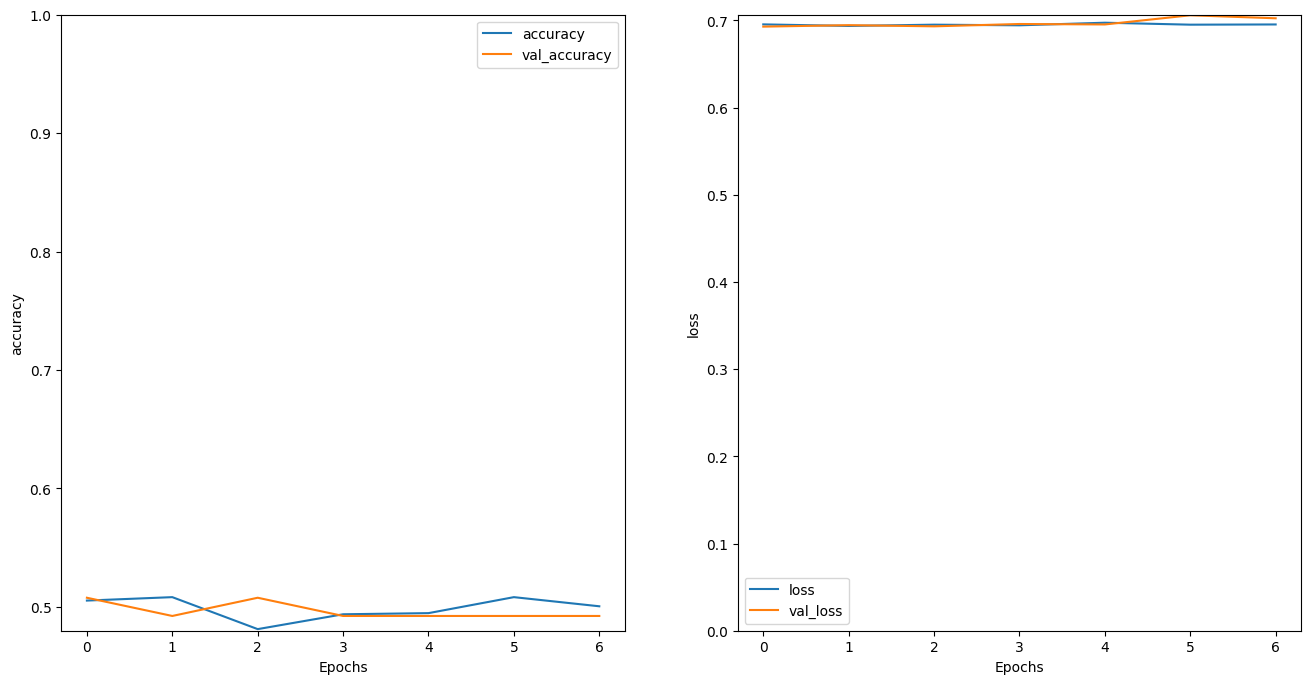

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
TEST_EVIDENCES_EX = [s[:VECTOR_MAX] for s in TEST_EVIDENCES_EX]
len(TEST_EVIDENCES_EX)

153

In [ ]:
len(TEST_HYPOTESIS)

153

In [ ]:
test_input = encode_data_to_tensors(TEST_HYPOTESIS, TEST_EVIDENCES_EX, tokenizer, VECTOR_MAX)

# check shape data 
print('DEBUG test shapes: ')
print(test_input['input_word_ids'].shape)
#print(test_input['input_mask'].shape)
#print(test_input['input_type_ids'].shape)

Dataset MAX (dim): 
189
DEBUG test shapes: 
(153, 300)


In [ ]:

c_counter = c_counter+1
gc.collect()
predictions = [np.argmax(i) for i in model.predict(test_input)]


submission = pd.DataFrame()
# print([i for i in model.predict(test_input)])

submission['UUID'] = TEST_UUID
submission['label'] = TEST_LABEL
submission['prediction'] = predictions

RESULTS_FILE = PREFIXG+"submission_" +str(c_counter)+"_"+stamp_time()+".csv"
RESULTS_FILE_R = PREFIXG+"results_" +str(c_counter)+"_"+stamp_time()+".json"
submission.to_csv(RESULTS_FILE, index = False)
submission.head()

5/5 [==============================] - 4s 207ms/step


,UUID,label,prediction
0,1adc970c-d433-44d0-aa09-d3834986f7a2,Contradiction,0
1,6b9162d0-0816-46d4-81af-c60028dcc63b,Contradiction,0
2,0b6cc8e3-69ee-4a91-b93d-2ad3fddce65f,Contradiction,0
3,cc1f712a-2116-4e40-9810-f315e3fa5ff8,Entailment,0
4,43ee7645-ce1e-42d5-9a74-3e379f6f367b,Contradiction,0


# Postprocessing

Conversion from json to csv of training, test and dev files. 

In [ ]:
import json
import pandas as pd


"""
type = train | dev
"""
def preprocessing(JSONPATH, type, PREFIX):

    with open(JSONPATH) as json_file:
        data = json.load(json_file)

    columns = ['Type', 'Section_id', 'Primary_id', 'Secondary_id', 'Statement', 'Label', ] #  'Primary_evidence_index', 'Secondary_evidence_index',

    ids = []
    types = []
    sectionId = []
    primaryId = []
    secondaryId = []
    statement = []
    label = []
    PEI = []
    SEI = []
    for entry in data:
        ids.append(entry)
        types.append(data[entry]['Type'])
        sectionId.append(data[entry]['Section_id'])
        primaryId.append(data[entry]['Primary_id'])
        if not (data[entry].get('Secondary_id') is None):
            secondaryId.append(data[entry]['Secondary_id'])
        else:
            secondaryId.append(None)
        statement.append(data[entry]['Statement'])
        label.append(data[entry]['Label'])
        PEI.append(','.join(str(x) for x in data[entry]['Primary_evidence_index']))
        if not (data[entry].get('Secondary_evidence_index') is None):
            SEI.append(','.join(str(x) for x in data[entry]['Secondary_evidence_index']))
        else:
            SEI.append(','.join(str(x) for x in []))

    df = pd.DataFrame()
    df['Id'] = ids
    df['Type'] = types
    df['Section_id'] = sectionId
    df['Primary_id'] = primaryId
    df['Secondary_id'] = secondaryId
    df['Statement'] = statement
    df['Label'] = label
    df['Primary_evidence_index'] = PEI
    df['Secondary_evidence_index'] = SEI

    #print(df.head(20))

    compression_opts = dict(method='zip', archive_name='out.csv') 
    # df.to_csv('out.zip', index=False, compression=compression_opts) 
    df.to_csv(PREFIX+type+'.csv', index=False) 



def collectEvidenceData(evidenceSection, evidenceIndexes, clinicalTrialId, evidenceSectionId, DEBUG2):
    evidences = []
    for evIndex in evidenceIndexes:
        try:
            i = int(evIndex)
            if DEBUG2:
                print(evidenceSection[i])
            evidences.append(evidenceSection[i].strip())
        except:
            print(evidenceIndexes)
            print('\n!!! Failed to collect evidence on index, trialId, section: ' + str(i) + clinicalTrialId, evidenceSectionId)
    return evidences

##
# TODO redefined but not used
##
def parseEvidenceSingleValidation(clinicalTrialId, evidenceSectionId, primaryEvidenceIndexes, PREFIX, DEBUG1, DEBUG2):
    if DEBUG1:
        print("Parse evidence Single: " + clinicalTrialId + " " + evidenceSectionId)
    CT_PATH = PREFIX+'/CT_data/'+clinicalTrialId+'.json'
    try:
        with open(CT_PATH) as json_file:
            dataCT = json.load(json_file)
            if DEBUG2:
                print(primaryEvidenceIndexes)
        evidences = collectEvidenceData(dataCT[evidenceSectionId], primaryEvidenceIndexes, clinicalTrialId, evidenceSectionId)
        if DEBUG2:
            print(evidences)    
    except:
        print('\n!!! Error for file: ' + clinicalTrialId)
    if DEBUG2:
        print("\n")
    return evidences


# preprocessing("/content/dev.json", "dev", "")

## Metrics (F1 score) script

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
import numpy
from sklearn.metrics import f1_score,precision_score,recall_score
RESULTS_FILE

'/content/submission_2_20230605205319.csv'

In [ ]:
import json
import pandas as pd
from functools import reduce 


dev_path = PREFIXG+"dev.json"
with open(dev_path) as json_file:
    dev = json.load(json_file)

def postProcessing(file):
    results2 = {}
    results = {}
    CT_index = 0
    try:
        STM = pd.read_csv(file)
        print(STM['prediction'].head(5))
        for id in STM['UUID']:
            prediction = STM['prediction'][CT_index]
            # print(prediction)
            CT_index = CT_index + 1
            if id in results:
              print("EROARE !!!!!")
              exit()
            else:
              results[id] = str(prediction)
    except Exception as err:
        print('\n! Error for file')
        print(err)
    return results


def run_score_script(Results):
    gold = dev
    results = Results
    uuid_list = list(results.keys())
    results_pred = []
    gold_labels = []
    for i in uuid_list:
        if results[i] == "1":
            results_pred.append(1)
        else:
            results_pred.append(0)
        if gold[i]["Label"] == "Entailment":
            gold_labels.append(1)
        else:
            gold_labels.append(0)

    print(gold_labels)
    print(results_pred)
    

    f_score = f1_score(gold_labels,results_pred)
    p_score = precision_score(gold_labels,results_pred)
    r_score = recall_score(gold_labels,results_pred)
    SCORE = "-".join(str(f_score).split("."))
    SCORE = SCORE[:6]

    print('F1:{:f}'.format(f_score))
    print('precision_score:{:f}'.format(p_score))
    print('recall_score:{:f}'.format(r_score))
    return SCORE

w = postProcessing(RESULTS_FILE)
SCORE = run_score_script(w)

0    0
1    0
2    0
3    0
4    0
Name: prediction, dtype: int64
[0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
F1:0.000000
pr

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run score script and write results in correct format

In [ ]:
with open(RESULTS_FILE_R, 'w') as convert_file:
  convert_file.write(json.dumps(w))

# Test.json Task 1

In [ ]:
# def parseEvSg(clinicalTrialId, evidenceSectionId, PREFIX, DEBUG1, DEBUG2):
#     evidences = []
#     if DEBUG1:
#         print("Load premises: " + clinicalTrialId + " " + evidenceSectionId)
#     CT_PATH = PREFIX+'CT_data/'+clinicalTrialId+'.json'
#     try:
#         with open(CT_PATH) as json_file:
#             dataCT = json.load(json_file)
#         evidences = dataCT[evidenceSectionId]
#         # if (len(premises) > 8):
#         #   num = 0
#         #   for prem in premises:
#         #     if (num % 2) == 0:
#         #       evidences.append(prem)
#         #       num = num + 1
#         #       print("PREMISE SELECTIE ----------------------------------")
#         # else:
#         #   print("PREMISE PUTINE ----------------------------------")
#         #   evidences = premises
#     except Exception as err:
#         print('\n!!! Error for file: ' + clinicalTrialId)
#         print(err)
#     if DEBUG2:
#         print("\n")
#     return evidences

In [ ]:
# TEST_STM_VALID = pd.read_csv(TEST_DATA2) #, nrows=40


# # exit()
# TEST_EVIDENCES_VALID=[]
# TEST_HYPOTESIS_VALID=[]
# TEST_UUID_VALID=[]
# CT_index = -1
# for id in TEST_STM_VALID['Id']:
#     evidences = []
#     CT_index = CT_index+1
#     CTid = TEST_STM_VALID['Primary_id'][CT_index]
#     hypotesis = normalizeDocument(TEST_STM_VALID['Statement'][CT_index], True)
#     hypotesisLen = len(hypotesis.split(' '))
#     if (TEST_STM_VALID['Type'][CT_index] == "Single"):
#       evidences = parseEvSg(CTid, TEST_STM_VALID['Section_id'][CT_index], PREFIX, DEBUG1, DEBUG2)
#       ax = splitEvidence([], "", "[CLS] "+hypotesis+" [SEP] ", evidences, 0, DEBUG2)
#       for evidenceFragment in ax:
#         # parse only evidences those that have a minimum of words 
#         if(hypotesisLen+len(evidenceFragment) > hypotesisLen + 10):
#           TEST_EVIDENCES_VALID.append(evidenceFragment)
#           TEST_HYPOTESIS_VALID.append(hypotesis)
#           TEST_UUID_VALID.append(id)
#       if DEBUG1:
#           print('Analyzed CT entry: ' + str(CT_index) + "  -  "+ CTid+"\n")
#     if (TEST_STM_VALID['Type'][CT_index] == "Comparison"):
#       CTidSecondary = TEST_STM_VALID['Secondary_id'][CT_index]
#       premisesPrimary = parseEvSg(CTid, TEST_STM_VALID['Section_id'][CT_index], PREFIX, DEBUG1, DEBUG2)
#       premisesSecondary = parseEvSg(CTidSecondary, TEST_STM_VALID['Section_id'][CT_index], PREFIX, DEBUG1, DEBUG2)
#       ax = splitEvidence([], "", hypotesis, premisesPrimary + premisesSecondary, 0, DEBUG2)
#       if (CT_index < 17):
#         print(hypotesis)
#       for evidenceFragment in ax:
#         # parse only evidences those that have a minimum of words 
#         if(hypotesisLen+len(evidenceFragment) > hypotesisLen + 10):
#           TEST_EVIDENCES_VALID.append(evidenceFragment)
#           TEST_HYPOTESIS_VALID.append(hypotesis)
#           TEST_UUID_VALID.append(id)
#         if (CT_index < 17):
#           print("     - "+ evidenceFragment)
#       # print("-------2--------")
#       if DEBUG1:
#           print('Analyzed CT entry: ' + str(CT_index) + "  -  "+ CTid+"\n")


In [ ]:
# validation_input = encode_data_to_tensors(TEST_HYPOTESIS_VALID, TEST_EVIDENCES_VALID, tokenizer, VECTOR_MAX)

# # check shape data 
# print('DEBUG test shapes: ')
# print(validation_input['input_word_ids'].shape)
# print(validation_input['input_mask'].shape)
# print(validation_input['input_type_ids'].shape)

In [ ]:
# predictions = [np.argmax(i) for i in model.predict(validation_input)]
# # print([i for i in model.predict(test_input)])

# submission = pd.DataFrame()
# submission['UUID'] = TEST_UUID_VALID
# submission['prediction'] = predictions

# RESULTS_TEST = PREFIXG+"/test-submission_" +str(c_counter)+"_"+SCORE  +".csv"
# RESULTS_TEST_R = PREFIXG+"/test-rez-"+SCORE+"__"+stamp_time()+".json"
# submission.to_csv(RESULTS_TEST, index = False)
# submission.head()

In [ ]:
# submission.to_csv(RESULTS_TEST, index = False)
# w = postProcessing(RESULTS_TEST)

# with open(RESULTS_TEST_R, 'w') as convert_file:
#   convert_file.write(json.dumps(w))